<a href="https://colab.research.google.com/github/tamtran4869/marketing_effectiveness_analysis/blob/main/Causal_inference_time_series_DiD_CausalImpact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal inference with Difference-in-Difference and CausalImpact package

In finding the effectiveness of media, and marketing campaigns (treatments) for an individual (e.g.normally it is a member, or a customer, etc.), we need to find the counterfactual outcome so we can compare it with the actual outcome.

The counterfactual outcomes could be obtained by getting from the matched individuals or using models for predicting it.

So to find the effect of campaigns over the time of an individual unit (e.g. normally it could be a store, a business, or a product line, etc.), we have 2 similar approaches by using
Difference-in-Difference (DiD) and time series prediction in CausalImpact package.

## Install and import packages

In [3]:
%%capture
!pip install pycausalimpact

In [4]:
# Helper packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.tsa.arima_process import ArmaProcess
import random

# Causal impact
from causalimpact import CausalImpact

## Synthetic data.

The synthetic data includes:
- Predictor: `Promoted_Items`
- Outcome: `Sales`
- Timestamp: `Week`(week 1 - week 500)
- Flag if the week is in the testing time: `Tested_Time`. In this case, we assume that stores started to boost media campaigns from week 301  to 500.
- Flag if the store is in the test group: `Tested_Store` (0: stores did not boost media and 1: stores boosted media)

The dataset contains only 2 stores: 1 in the test group and 1 in the control group.

In [57]:
# Set up a seed for reproducibility
np.random.seed(123)
# Autoregressive coefficients
arparams = np.array([.95, .05])
# Moving average coefficients
maparams = np.array([.6, .3])
# Create a ARMA process
arma_process = ArmaProcess.from_coeffs(arparams, maparams)
# Create the control time-series
X = 10 + arma_process.generate_sample(nsample=500)


# Create the response time-series
y = 2 * X + np.random.normal(size=500)
y1 = 2 * X + np.random.normal(size=500) + arma_process.generate_sample(nsample=500)

# Add the true causal impact for tested stores
y1[300:] += 15

# Merge data and flag if the store is in test group
df1 = pd.DataFrame({'Promoted_Items': abs(X.round()),
               'Sales': abs(y1)})
df1['Tested_Store'] = 1
df0 = pd.DataFrame({'Promoted_Items': abs(X.round()),
               'Sales': abs(y)})
df0['Tested_Store'] = 0

# Merge for the final data
df=pd.concat([df0,df1])

# Adding week and testing time features
df['Week'] = [i for i in range(1,501)]*2
df['Tested_Week'] = df['Week']>300
df.head()

,Promoted_Items,Sales,Tested_Store,Week,Tested_Week
0,9.0,18.580772,0,1,False
1,9.0,18.698877,0,2,False
2,10.0,19.435159,0,3,False
3,9.0,18.502012,0,4,False
4,7.0,16.144691,0,5,False


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 499
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Promoted_Items  1000 non-null   float64
 1   Sales           1000 non-null   float64
 2   Tested_Store    1000 non-null   int64  
 3   Week            1000 non-null   int64  
 4   Tested_Week     1000 non-null   bool   
dtypes: bool(1), float64(2), int64(2)
memory usage: 40.0 KB


In [59]:
df.describe()

,Promoted_Items,Sales,Tested_Store,Week
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,16.938000,40.884190,0.50000,250.500000
std,9.992497,29.042816,0.50025,144.409501
min,0.000000,0.077253,0.00000,1.000000
25%,9.000000,16.775952,0.00000,125.750000
50%,16.000000,34.689658,0.50000,250.500000
75%,23.000000,61.723924,1.00000,375.250000
max,41.000000,110.732916,1.00000,500.000000


Text(0.5, 1.0, 'Sales and number of promoted items in the test store during weeks')

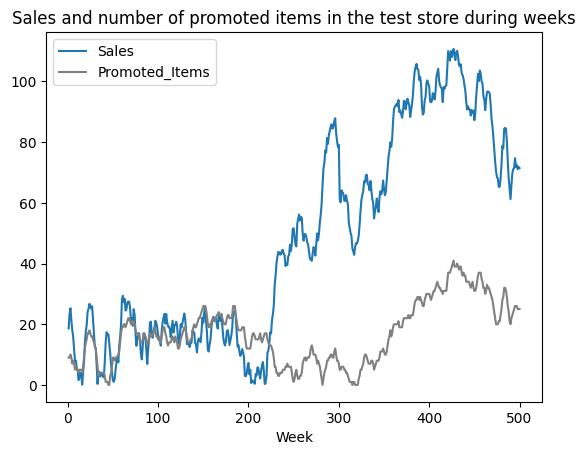

In [60]:
#EDA
df[df['Tested_Store']==1].groupby('Week')['Sales'].mean().plot(label = 'Sales' )
df[df['Tested_Store']==1].groupby('Week')['Promoted_Items'].mean().plot( label = 'Promoted_Items', color = 'grey')
plt.legend()
plt.title ('Sales and number of promoted items in the test store during weeks')

As we can see, both sales and the number of promoted items increased in the last part, so how we can credit the increase in sales for the media boosting campaigns?

We could not give all credit for the boosting campaigns since the number of promoted items seems to have some effects on the sales and we also have the organic growth.

Answer: Why we don't compare it with a store having the same number of promoted items and not having boosting campaigns (a control store)? -> DiD

## DiD

Like the matching method in causal inference for an individual, we need to have another store to compare with. The idea is to compare differences between the test store and the control store before and during/after the boosting time.

We could use the `ols` function to model the sales with formula:

`Sales` = b0 + b1`Tested_Store` + b2*`Tested_Week` + b3*(`Testing_Store*Tested_Week`) + b4*`Promoted_Items` + e


In [65]:
# Compute diff in diff
s = df.groupby(['Tested_Store','Week'])['Sales'].mean().reset_index()
s0 = s[s.Tested_Store == 0]
s1 = s[s.Tested_Store == 1]

c_before = round(s0.query('Week<=300')['Sales'].mean(),2)
c_after = round(s0.query('Week>300')['Sales'].mean(),2)
t_before = round(s1.query('Week<=300')['Sales'].mean(),2)
t_after = round(s1.query('Week>300')['Sales'].mean(),2)

print('Control before: %s - Control after: %s \nTest before: %s - Test after: %s \nDiff before: %.2f - Diff after: %.2f \nDiff-in-Diff: %.2f' % (c_before, c_after, t_before,t_after,
                                                                                                                                                  t_before-c_before,
                                                                                                                                                  t_after-c_after,
                                                                                                                                                  (t_after-c_after)-(t_before-c_before)))

Control before: 26.45 - Control after: 45.25 
Test before: 24.45 - Test after: 82.81 
Diff before: -2.00 - Diff after: 37.56 
Diff-in-Diff: 39.56


The effect is 39.56. Is it significant?

In [61]:
# Modelling
m = ols('Sales ~ Tested_Store*Tested_Week + Promoted_Items', data=df).fit(cov_type = 'cluster',
                                                                          cov_kwds = {'groups':np.array(df[['Tested_Store']])},
                                                                          use_t = True)
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                    0.9710
Date:                Thu, 21 Sep 2023   Prob (F-statistic):              0.505
Time:                        09:51:11   Log-Likelihood:                -4094.7
No. Observations:                1000   AIC:                             8199.
Df Residuals:                     995   BIC:                             8224.
Df Model:                           4                                         
Covariance Type:              cluster                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '


Although `Tested_Week` is insignificant, its interaction with `Tested_Store` is significant with coef 39.56. So can we conclude that the media campaign's effect is 39.56 and significantly affects the sales? Not yet.

The DiD comes with an assumption - the parallel trend assumption. We can check through the visualisation below.


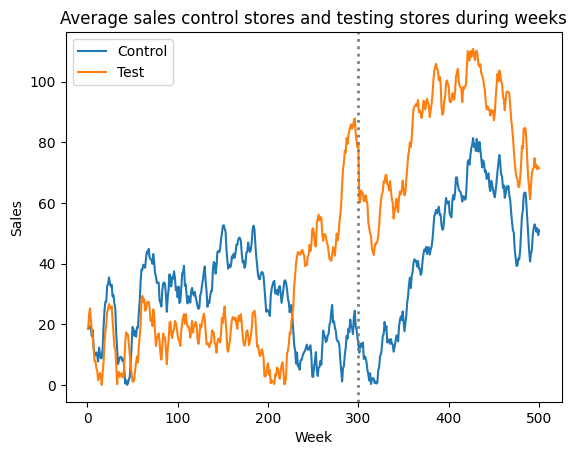

In [67]:
# Visualisation
plt.title("Average sales control stores and testing stores during weeks")
plt.plot(s0['Week'], s0['Sales'], label='Control')
plt.plot(s1['Week'], s1['Sales'], label='Test')
plt.axvline(x=300, color='grey', ls=':', lw=2)
plt.ylabel("Sales")
plt.xlabel("Week")
plt.legend()
plt.show()

We can see there is no parallel trend between sales of 2 stores.
- In the first 50 weeks, the difference was small.
- Then from week 50 to around week 220, the space became bigger
- After that and before the campaign, the test store sales increased while the control store went down.

The assumption is not realistic. It is one of the limitations of this method.

Another limitation is, with 3 predictors: `Tested_Store`, `Tested_Week` and `Testing_Store*Tested_Week`, we can only capture sales in 4 points: test store before, test store after, control store after and before. There is no predictor for sales time series components (e.g. trend, seasonal). Therefore the model did not consider effects over time.

## CausalImpact Model

As I understand, the method used in the CausalImpact library is to model time series sales (Bayesian structural time series models) before the campaigns and use it to predict the counterfactual outcome (sales after the campaigns of the tested store). It is a method using machine learning models to predict counterfactual outcomes.

So in this case, we only need data from the tested store.


In [76]:
# Extract required data for CausalImpact model.
s= df1[['Sales','Promoted_Items']]
s['Week'] = pd.date_range('2013-01-01', freq='W', periods=500)
s= s.set_index('Week')
s.head()

,Sales,Promoted_Items
Week,,
2013-01-06,18.637485,9.0
2013-01-13,23.253568,9.0
2013-01-20,25.276213,10.0
2013-01-27,21.321799,9.0
2013-02-03,18.143423,7.0


The pre-period is ['2013-01-06 00:00:00', '2018-09-30 00:00:00']
The post-period is ['2018-10-07 00:00:00', '2022-07-31 00:00:00']


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Valu

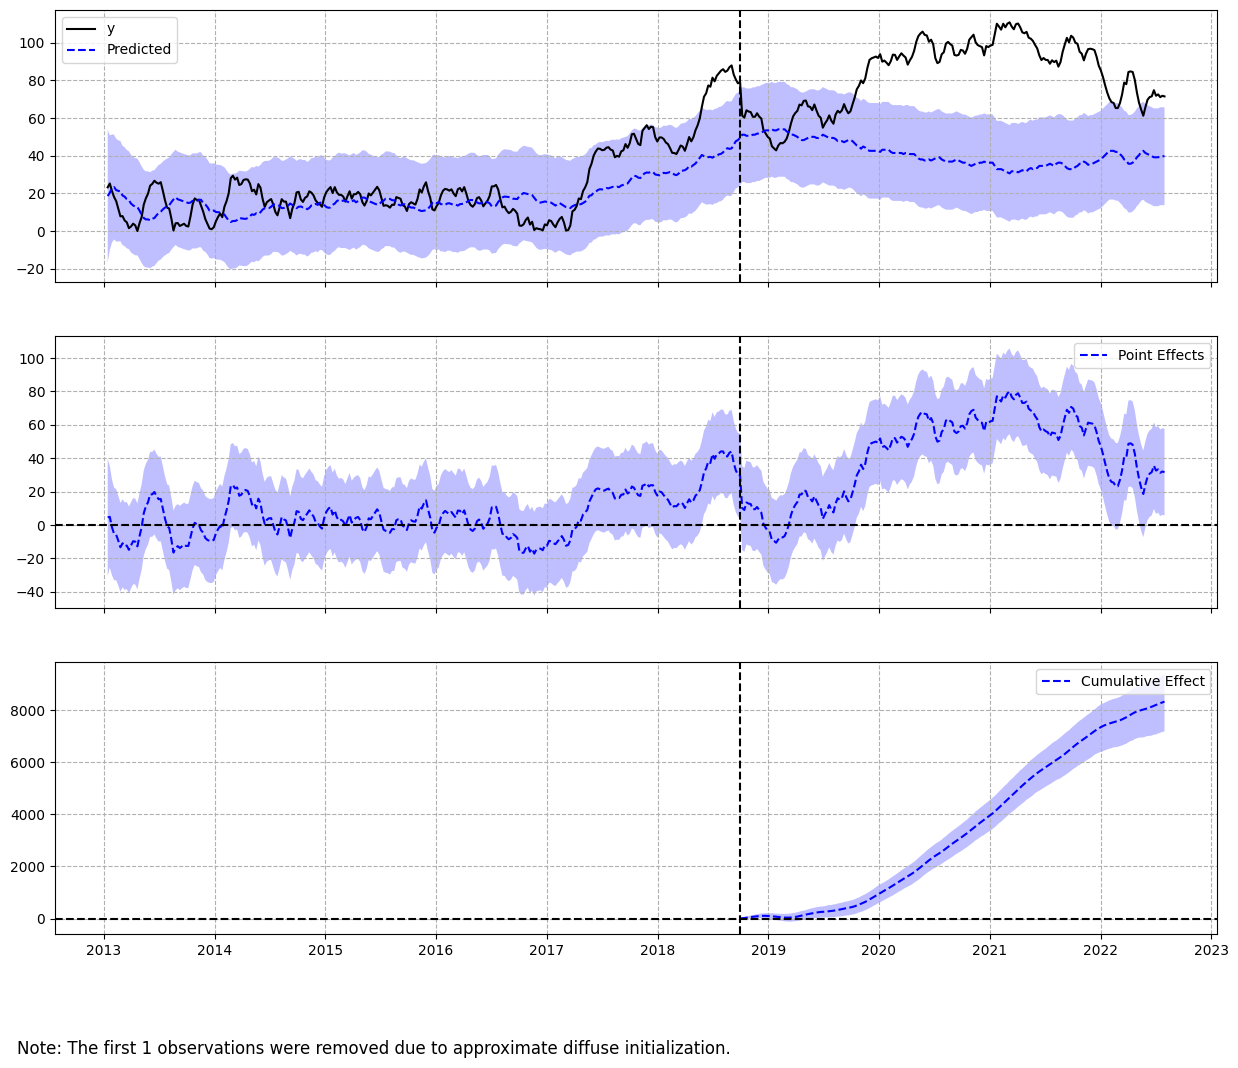

In [77]:
# Set pre-period
pre_period = [str(s.index.min()), str(s.index[299])]
# Set post-period
post_period = [str(s.index[300]), str(s.index.max())]
# Print out the values
print(f'The pre-period is {pre_period}')
print(f'The post-period is {post_period}')

# CausalImpact model
impact = CausalImpact(data=s, pre_period=pre_period, post_period=post_period)
impact.plot()

In [79]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    82.81              16562.54
Prediction (s.d.)         41.15 (2.78)       8230.26 (556.57)
95% CI                    [35.97, 46.88]     [7194.08, 9375.8]

Absolute effect (s.d.)    41.66 (2.78)       8332.28 (556.57)
95% CI                    [35.93, 46.84]     [7186.74, 9368.46]

Relative effect (s.d.)    101.24% (6.76%)    101.24% (6.76%)
95% CI                    [87.32%, 113.83%]  [87.32%, 113.83%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [80]:
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 82.81. By contrast, in the absence of an
intervention, we would have expected an average response of 41.15.
The 95% interval of this counterfactual prediction is [35.97, 46.88].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 41.66 with a 95% interval of
[35.93, 46.84]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 16562.54.
By contrast, had the intervention not taken place, we would have expected
a sum of 8230.26. The 95% interval of this prediction is [7194.08, 9375.8].


The above results are given in terms of absolute numbers. In relative
terms, the response va

This effect is 41.66 with a 95% interval of
[35.93, 46.84]. It is different from the DiD method.

I am learning and would greatly appreciate any suggestions. Thank you.

# REFERENCES

http://google.github.io/CausalImpact/CausalImpact.html

https://towardsdatascience.com/causal-inference-using-difference-in-differences-causal-impact-and-synthetic-control-f8639c408268

https://medium.com/grabngoinfo/time-series-causal-impact-analysis-in-python-63eacb1df5cc
